# Read the HEA data and prepare it for analysis
Both the random generated configurations and the MC simulated configurations are used, under directory Random_{HEA} and MC_{HEA} respectively

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
from os import listdir

def convert_to_key(list1):
    r"""
    Convert a position to a string, to be used as dictionary key to 
    find the corresponding element 
    """
    key = ""
    for i in list1:
        key += "%03d"%i
    return key

def convert_key_to_list(key):
    r"""
    Convert a position to a string, to be used as dictionary key to 
    find the corresponding element 
    """
    assert len(key) == 9, "format of key is incorrect when convert_key_to_list"
    x = int(key[:3])
    y = int(key[3:6])
    z = int(key[6:9])
    return [x, y, z]

def distance(list1):
    r"""
    Calculate the Euclidean distance between two positions
    """
    from functools import reduce
    return np.sqrt(reduce((lambda x, y: x + y), list(map(lambda x: x*x, list1))))

def add_list(list1, list2):
    r"""
    Add two position vectors, mainly to move from local positions to global positions
    """
    assert len(list1) == len(list2), "list1 and list2 must be of equal length"
    result = []
    for i in range(len(list1)):
        result.append(list1[i] + list2[i])
    return result

def build_neighbor_cell(lx_in, ly_in, lz_in):
    r"""
    Return a list of lattice positions (cell) in the supercell of size (lx, ly, lz
    """
    cell = []
    for i in range(-lx_in, lx_in+1):
        for j in range(-ly_in, ly_in+1):
            for k in range(-lz_in, lz_in+1):
                cell.append([2*i, 2*j, 2*k])

    for i in range(-lx_in, lx_in):
        for j in range(-ly_in, ly_in):
            for k in range(-lz_in, lz_in):
                cell.append([2*i+1, 2*j+1, 2*k+1])
    return cell 

def position_in_cell(list1, lx_SC, ly_SC, lz_SC):
    """
    Move global position list1 inside the supercell.
    Note lx(yz)_SC is different from the lx(yz) in the "local interaction zone" cell
    """
    assert len(list1) == 3, "position must be of format [x, y, z]"
    x = list1[0]%lx_SC
    y = list1[1]%ly_SC
    z = list1[2]%lz_SC
    result = [x, y, z]
    return result

def find_neighbors_position(position, tmp_neighbors, lx_SC, ly_SC, lz_SC):
    r"""
    Find the neigbhoring positions around "position" within LIZ, 
    make sure the neighboring positions are within the supercell defined by lx(yz)_SC,
    tmp_neighbors is the neighbor positions when "position=[0,0,0]"
    """
    result = []
    for i in tmp_neighbors: 
        mid = []
        for j in i:
            mid.append(position_in_cell(add_list(j, position), lx_SC, ly_SC, lz_SC))
            #mid.append(position_in_cell([j[i] + position[i] for i in range(3)], lx_SC, ly_SC, lz_SC))
            # list comprehension is a little faster than add_list
        result.append(mid)
    return result

def get_elements(data_dir):
    r"""
    Record the different elements in the material.
    """
    if data_dir[-1] != "/": # make sure symmetry_file is in directory format
        data_dir += "/" 
    cell = listdir(data_dir)[0]
    config = listdir(data_dir + '/' + cell)[0]
    file_name = data_dir + cell + '/' + config + "/position.dat"
    with open(file_name) as file:
        data = file.readlines()
    data = data[6:]
    data = [i.split() for i in data]
    list_tmp = []
    for i in data:
        if i[0] not in list_tmp:
            list_tmp.append(i[0])
    list_tmp.sort()    
    return list_tmp

def get_pair_key(element_list):
    r"""
    Record the n(n+1)/2 (n is the number of element) pair keys: e.g. MoMo, MoNb, MoTa ...
    """
    keys = list(set(element_list))
    keys.sort()
    pairs = []
    for i in range(len(keys)):
        for j in range(i, len(keys)):
            pairs.append(keys[i] + keys[j])
    return pairs

def get_pair_key_short(element_list):
    r"""
    Record the n(n-1)/2 (n is the number of element) independent pair keys: e.g. MoNb, MoTa ...
    """
    keys = list(set(element_list))
    keys.sort()
    pairs = []
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            pairs.append(keys[i] + keys[j])
    return pairs

class Pair_energy():
    def __init__(self, data_dir, n_shell, cell_sizes, n_configuration=10, verbose = False):
        t0 = time.process_time()
        self.data_dir = data_dir
        if self.data_dir[-1] != "/": # make sure the file is in directory format
            self.data_dir += "/" 
        self.n_shell = n_shell
        if not cell_sizes:            
            self.cell_sizes = listdir(self.data_dir)
        else:
            self.cell_sizes = cell_sizes  
        self.n_configuration = n_configuration
        self.cells_lxyz = self._get_cells_lxyz()
        
        self.tmp_neighbors = self._find_neighbors([0,0,0], build_neighbor_cell(4,4,4), self.n_shell)
        self.n_atom_neighbor = sum([len(i) for i in self.tmp_neighbors]) - 1

        self.data_read, self.data_energy = self._read_data(self.data_dir, self.n_configuration)
        
        self.elements = get_elements(self.data_dir)
        self.elements.sort()
        
        self.X_data = {}
        self.pair_key = get_pair_key(self.elements)
        self.pair_key_short = get_pair_key_short(self.elements)
        
        self.X_data = []
        for key in self.data_read:
            if verbose:
                print(key)
            self.X_data.append(self._get_config_data(key))

        self.X_data = np.array(self.X_data)
        self.y_data = np.array(list(self.data_energy.values()))
        self.row_index = list(self.data_energy.keys())
        self.col_index = []
        for i in range(1, self.n_shell+1):
            self.col_index += [j+'_'+str(i) for j in self.pair_key]
        self.col_index_short = []
        for i in range(1, self.n_shell+1):
            self.col_index_short += [j+'_'+str(i) for j in self.pair_key_short] 
        if verbose:
            print("Total cpu time is ", time.process_time()-t0)
        
    def _get_cells_lxyz(self):
        r"""
        Record the lattice information of the supercells.
        output: {cell: (lx, ly, lz)}
        """
        data_dir = self.data_dir
        data_out = {}
        cell_sizes=listdir(data_dir)
        for cell in cell_sizes:
            config = listdir(data_dir + cell + '/')[0]
            file_name = data_dir + cell + '/' + config + '/' + 'position.dat'
            with open(file_name) as file:
                data = file.readlines()
            a = float(data[0].split()[1])
            ahalf = a/2.0
            data_cell = [i.split() for i in data[1:4]] 
            data_cell = np.array(data_cell, dtype = float)
            lx = int(round(data_cell[0,0]/ahalf))
            ly = int(round(data_cell[1,1]/ahalf))
            lz = int(round(data_cell[2,2]/ahalf))
            data_out[cell] = (lx, ly, lz)
        return data_out
    
    def _find_neighbors(self, init_posi, neighbors, n_shell):
        r"""
        Group the neighbors according to their distances to init_posi.
        """
        distances = [distance(i) for i in neighbors]
        neighbors_global = [add_list(i, init_posi) for i in neighbors]
        neighbor_frame = pd.DataFrame(neighbors_global)
        neighbor_frame["distance"] = distances
        unique_d = [i for i in neighbor_frame["distance"].unique()]
        unique_d.sort()
        neighbor_list = [np.array(neighbor_frame[neighbor_frame["distance"] == i].iloc[:,0:3]).tolist()
                         for i in unique_d]
        assert n_shell < len(neighbor_list), "n_shell is too large and LIR is outside build_neighbor_cell "        
        return neighbor_list[0:n_shell+1]
    
    def _record_position(self, file_config):
        r"""
        Record the elements and energies of the atoms for a given configuration.
        output: {position: element}
        """    

        if file_config[-1] != "/": # make sure symmetry_file is in directory format
            file_config += "/" 

        file_name = file_config + "position.dat"
        with open(file_name) as file:
            data = file.readlines()
        a = float(data[0].split()[1])
        ahalf = a/2.
        cell = [i.split() for i in data[1:4]] 
        cell = np.array(cell, dtype = float)
        data = data[6:] # x, y, z data start from the 6th row in the position.dat file
        data = [i.split() for i in data]
        position_list = []
        ele_list = []
        for i in range(len(data)):
            ele_list.append(data[i][0])
            x = int(round( float(data[i][1]) / ahalf ))
            y = int(round( float(data[i][2]) / ahalf ))
            z = int(round( float(data[i][3]) / ahalf )) 
            key = convert_to_key((x, y, z))
            #key = "%03d"*3%(x, y, z)
            position_list.append(key)        
        assert len(ele_list) == len(position_list), "different list sizes in record_y()"   
        data_out = {}
        for i in range(len(ele_list)):
            data_out[position_list[i]] = ele_list[i]
        return data_out
    
    def _read_data(self, data_dir, n_configuration):
        r"""
        Read all the data in the sub-directories of data_dir.
        *if n_configuration > 0, use the first n_configuration, else use all available configurations*
        output: {cell_config: {position: element}}
            eg. {"320Atom_68": {"006002006": V}}
        """
        cell_sizes = self.cell_sizes
        
        if data_dir[-1] != "/": # make sure symmetry_file is in directory format
            data_dir += "/"   
        data_out = {}
        data_energy = {}
        for cell in cell_sizes:
            # if n_configuration > 0, use the first n_configuration, else use all configurations
            configurations = listdir(data_dir + cell + '/')
            configurations.sort()
            if n_configuration > 0:
                configurations = configurations[:n_configuration]
            for config in configurations:
                file_config = data_dir + cell + '/' + config + '/'
                key_row = cell + '_' + config
                data_out[key_row] = self._record_position(file_config)

                txt = listdir(file_config)    
                file_name = file_config + "/" + [i for i in txt if i[:3] == "k_n"][0] # find the file start with "k_n"
                with open(file_name) as file:
                    data = file.readlines()
                data_energy[key_row] = float(data[-1].split()[2])            
        return data_out, data_energy
    
    def _get_config_data(self, key):
        r"""
        Get the X and y data for a given key(e.g. '20Atom_1'). 
        """
        lx_SC, ly_SC, lz_SC = self.cells_lxyz[key.split('_')[0]]
        data = self.data_read[key]
        
        record = [{i:0 for i in self.pair_key} for j in range(self.n_shell)]
        for i_shell in range(1, self.n_shell+1): # start from 1 to avoid the centering atom
            for key_posi in data:
                position_local = convert_key_to_list(key_posi)
                neighbors = find_neighbors_position(position_local, self.tmp_neighbors, lx_SC, ly_SC, lz_SC) 
                ele_1 = data[convert_to_key(position_local)]
                for position in neighbors[i_shell]:
                    ele_2 = data[convert_to_key(position)]
                    k12 = [ele_1, ele_2]
                    k12.sort()
                    pair_key = k12[0]+k12[1]
                    record[i_shell-1][pair_key] += 1
        data_out = []
        for i in record:
            total = float(sum(i.values()))
            for j in i:
                data_out.append(i[j]/total)
        return data_out             

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def LR_plot(data_X, data_y, test_size_in = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, random_state = 100,
                                                        test_size= test_size_in)
    reg_lin = BayesianRidge()
    reg_lin.fit(X_train, y_train)
    
    y_pred = reg_lin.predict(X_train)
    plt.plot(y_train, y_pred,"ro")
    print(r"training R^2 score is ", r2_score(y_train, y_pred))
    print(r"training RMSE is ", np.sqrt(mean_squared_error(y_train, y_pred)))
    plt.xlabel(r"$E_{train}$ (Ry)")
    plt.ylabel(r"$E_{pred}$ (Ry)")
    plt.show()

    y_pred = reg_lin.predict(X_test)
    plt.plot(y_test, y_pred, "bo", markersize=2)
    print(r"testing R^2 score is ", r2_score(y_test, y_pred))
    print(r"testing MSE is ", np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.xlabel(r"$E_{test}$ (Ry)")
    plt.ylabel(r"$E_{test_pred}$ (Ry)")
    plt.show()    
    return reg_lin

In [5]:
import os
code_dir = os.getcwd()
home_dir = code_dir 

## MoNbTaW

128Atom_1
128Atom_100
128Atom_101
128Atom_102
128Atom_103
128Atom_104
128Atom_105
128Atom_106
128Atom_107
128Atom_108
128Atom_109
128Atom_110
128Atom_111
128Atom_112
128Atom_113
128Atom_114
128Atom_115
128Atom_116
128Atom_117
128Atom_118
128Atom_119
128Atom_120
128Atom_121
128Atom_122
128Atom_123
128Atom_124
128Atom_125
128Atom_126
128Atom_127
128Atom_128
128Atom_129
128Atom_130
128Atom_131
128Atom_132
128Atom_133
128Atom_134
128Atom_135
128Atom_136
128Atom_137
128Atom_138
128Atom_139
128Atom_140
128Atom_141
128Atom_142
128Atom_143
128Atom_144
128Atom_145
128Atom_146
128Atom_147
128Atom_148
128Atom_149
128Atom_150
128Atom_151
128Atom_152
128Atom_153
128Atom_154
128Atom_155
128Atom_156
128Atom_157
128Atom_158
128Atom_159
128Atom_160
128Atom_161
128Atom_162
128Atom_163
128Atom_164
128Atom_165
128Atom_166
128Atom_167
128Atom_168
128Atom_169
128Atom_170
128Atom_171
128Atom_172
128Atom_173
128Atom_174
128Atom_175
128Atom_176
128Atom_177
128Atom_178
128Atom_179
128Atom_180
128Atom_181
128Ato

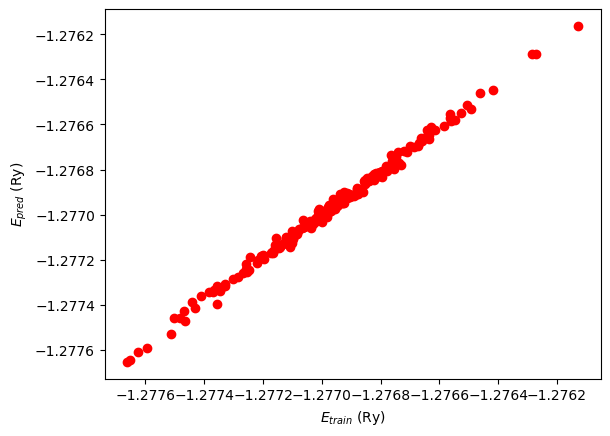

testing R^2 score is  0.9924229537169282
testing MSE is  2.4260343175438053e-05


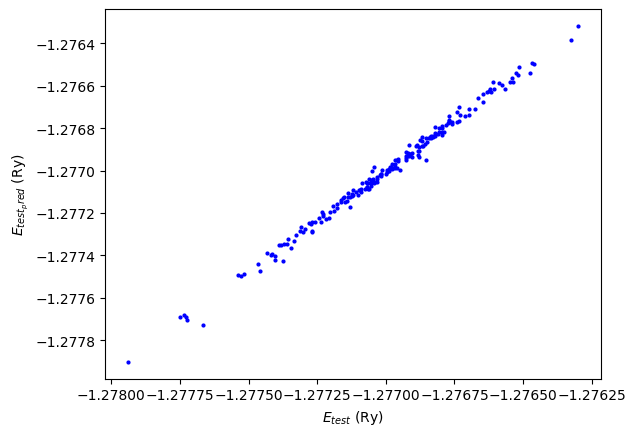

<BarContainer object of 36 artists>

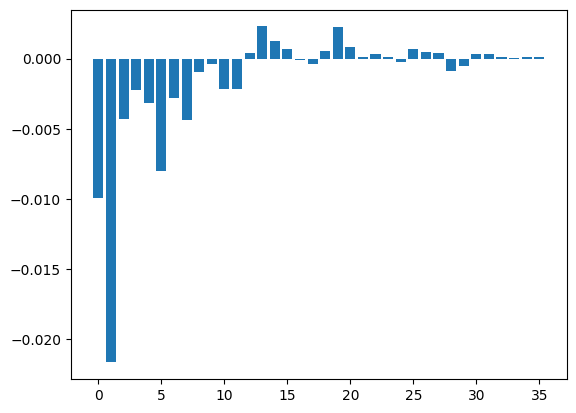

In [6]:
data_dir = os.path.join(home_dir, "Random_MoNbTaW")

test = Pair_energy(data_dir, n_shell=6, cell_sizes=[], n_configuration=100, verbose = True)

X_data = pd.DataFrame(test.X_data, columns=test.col_index, index=test.row_index)
X = X_data[test.col_index_short]
y = test.y_data

reg = LR_plot(X, y) 
plt.bar(range(len(reg.coef_)), reg.coef_)

In [7]:
X_data

,MoMo_1,MoNb_1,MoTa_1,MoW_1,NbNb_1,NbTa_1,NbW_1,TaTa_1,TaW_1,WW_1,...,MoMo_6,MoNb_6,MoTa_6,MoW_6,NbNb_6,NbTa_6,NbW_6,TaTa_6,TaW_6,WW_6
128Atom_1,0.070312,0.119141,0.113281,0.126953,0.052734,0.136719,0.138672,0.066406,0.117188,0.058594,...,0.062500,0.104167,0.114583,0.156250,0.057292,0.156250,0.125000,0.062500,0.104167,0.057292
128Atom_100,0.060547,0.117188,0.130859,0.130859,0.044922,0.138672,0.154297,0.056641,0.117188,0.048828,...,0.052083,0.135417,0.145833,0.114583,0.046875,0.135417,0.135417,0.046875,0.125000,0.062500
128Atom_101,0.056641,0.140625,0.126953,0.119141,0.066406,0.111328,0.115234,0.064453,0.132812,0.066406,...,0.057292,0.135417,0.125000,0.125000,0.036458,0.098958,0.192708,0.088542,0.098958,0.041667
128Atom_102,0.068359,0.109375,0.130859,0.123047,0.070312,0.125000,0.125000,0.062500,0.119141,0.066406,...,0.052083,0.140625,0.156250,0.098958,0.067708,0.088542,0.135417,0.052083,0.151042,0.057292
128Atom_103,0.062500,0.136719,0.109375,0.128906,0.056641,0.123047,0.126953,0.076172,0.115234,0.064453,...,0.057292,0.140625,0.130208,0.114583,0.057292,0.130208,0.114583,0.052083,0.135417,0.067708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256Atom_194,0.064453,0.125977,0.116211,0.128906,0.065430,0.126953,0.116211,0.061523,0.133789,0.060547,...,0.052083,0.118490,0.132812,0.144531,0.076823,0.106771,0.121094,0.067708,0.125000,0.054688
256Atom_195,0.053711,0.136719,0.119141,0.136719,0.055664,0.129883,0.122070,0.064453,0.122070,0.059570,...,0.063802,0.144531,0.114583,0.113281,0.053385,0.126302,0.122396,0.062500,0.134115,0.065104
256Atom_196,0.050781,0.129883,0.125977,0.142578,0.062500,0.134766,0.110352,0.053711,0.131836,0.057617,...,0.069010,0.125000,0.114583,0.122396,0.055990,0.136719,0.126302,0.063802,0.121094,0.065104
256Atom_197,0.056641,0.115234,0.128906,0.142578,0.062500,0.133789,0.125977,0.065430,0.106445,0.062500,...,0.048177,0.140625,0.114583,0.148438,0.050781,0.128906,0.128906,0.061198,0.134115,0.044271


In [10]:
import os

# read the positions and calculate the features
new_data_dir = os.path.join(home_dir, "MC_MoNbTaW/MC_data")
files = sorted(os.listdir(new_data_dir))
new_data_X = []
for file in files:
    with open(os.path.join(new_data_dir, file), 'r') as fp:
        lines = fp.readlines()
        data_raw = [float(i) for i in lines[2].split()]
        new_data_X.append(data_raw)
        
# read DFT energis from the file       
with open(os.path.join(home_dir, "MC_MoNbTaW/DFT_energy.dat")) as fp:
    data = [i.split(",") for i in  fp.read().splitlines()]  
energy_dict = {}
for i, j in data:
    energy_dict[i] = float(j)
new_data_y_DFT = [energy_dict[i] for i in sorted(energy_dict)]

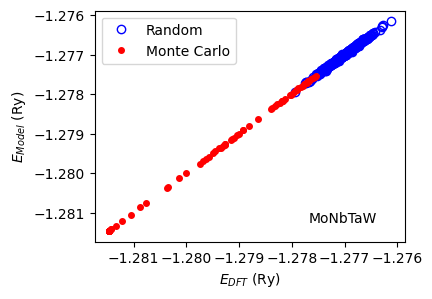

In [14]:
fig, ax = plt.subplots(figsize=(4,3))

X_old = np.array(X)
y_old = np.array(y)
X_all = np.concatenate((X_old, np.array(new_data_X)))
y_all = np.concatenate((y_old, np.array(new_data_y_DFT)))

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
y_pred = reg_lin.predict(X_all)
#plt.plot(y_all, y_pred, "ro", label="Old and additional energies")

X_new = np.array(new_data_X)
y_new = np.array(new_data_y_DFT)
plt.plot(y_old, reg_lin.predict(X_old), 'o', markerfacecolor='none', 
         label="Random", markeredgecolor='b',  markersize=6)
plt.plot(y_new, reg_lin.predict(X_new), "ro", label="Monte Carlo", markersize=4)
plt.legend()
plt.xlabel(r"$E_{DFT}$ (Ry)")
plt.ylabel(r"$E_{Model}$ (Ry)")
#plt.title(r"$R^2$=%.4f, MSRE=%.4f mRy"%(r2_score(y_all, y_pred), 
#                                    1000*np.sqrt(mean_squared_error(y_all, y_pred))))

plt.text(0.8, 0.1,'MoNbTaW',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

plt.savefig(os.path.join(home_dir, "figures/MoNbTaW_energy.pdf"), dpi = None, facecolor = 'w', edgecolor = 'w',
     format = 'pdf',
    transparent = False, bbox_inches = 'tight', pad_inches = 0.1)

reg_lin.coef_
[-1.04916586e-02 -2.26029824e-02 -4.78936497e-03 -2.74579237e-03
 -3.65031822e-03 -8.50712729e-03 -2.82050774e-03 -4.47913455e-03
 -1.21451648e-03 -5.46275517e-04 -2.53566865e-03 -2.52228582e-03
  2.81365516e-04  1.98373120e-03  1.23430232e-03  4.07628980e-04
 -3.13095878e-04 -4.27895381e-04  9.13055049e-04  3.30015984e-03
  1.21298911e-03  2.44490929e-04  2.91732347e-04  6.02655626e-04
 -6.05193480e-04  5.24595770e-04  5.95010812e-04  1.63459894e-04
 -9.33250721e-04 -7.54173358e-04  1.91361438e-04  2.36351619e-04
  9.33819893e-05  9.14772147e-06  1.70173719e-04  1.05938167e-04]
reg_lin.intercept_
-1.2697809621756564


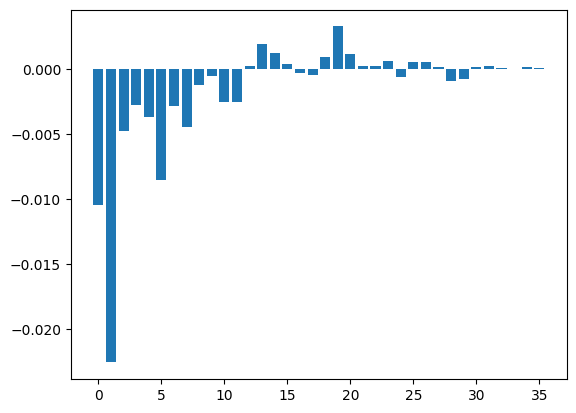

In [15]:
# Color plot to be added by Jiaxin
plt.bar(range(len(reg_lin.coef_)), reg_lin.coef_)
print("reg_lin.coef_")
print(reg_lin.coef_)
print("reg_lin.intercept_")
print(reg_lin.intercept_)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.5,
                                                    random_state = 111)
reg_lin = BayesianRidge()
reg_lin.fit(X_train, y_train)

print("Training R2 score = %f"%r2_score(y_train, reg_lin.predict(X_train)))
print("Testing R2 score = %f"%r2_score(y_test, reg_lin.predict(X_test)))


print("Training mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_train, reg_lin.predict(X_train)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_test, reg_lin.predict(X_test)))))

Training R2 score = 0.999785
Testing R2 score = 0.999322
Training mean sequre error = 0.016415 mRy
Testing mean sequre error = 0.023589 mRy


In [17]:
print("Fit with data_old")
reg_lin = BayesianRidge()
reg_lin.fit(X_old, y_old)

#print("Training R2 score = %f"%r2_score(y_old, reg_lin.predict(X_old)))
#print("Testing R2 score = %f"%r2_score(y_all, reg_lin.predict(X_all)))

#print("Training mean sequre error = %f mRy"
#      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

print("="*50)
print("Fit with data_all")
reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

Fit with data_old
Testing mean sequre error = 0.058184 mRy
Testing mean sequre error = 0.017052 mRy
Testing mean sequre error = 0.143450 mRy
Fit with data_all
Testing mean sequre error = 0.017054 mRy
Testing mean sequre error = 0.017916 mRy
Testing mean sequre error = 0.011102 mRy


### Using all the data (both random and MC)

training R^2 score is  0.9996589446758165
training RMSE is  1.7578176267867063e-05


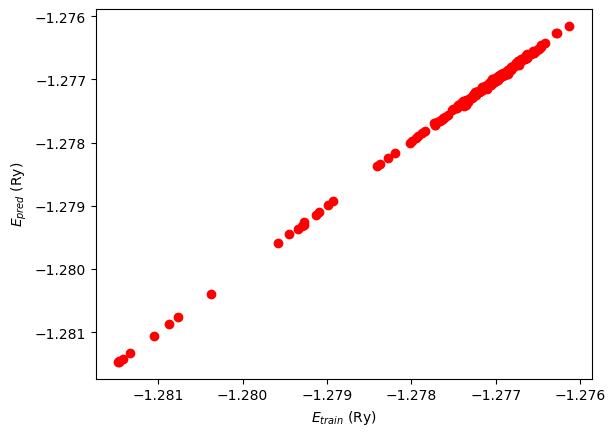

testing R^2 score is  0.9996096412989507
testing MSE is  2.13553176745462e-05


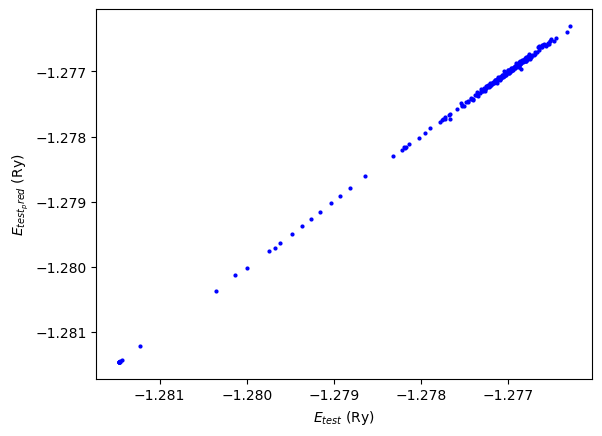

<BarContainer object of 36 artists>

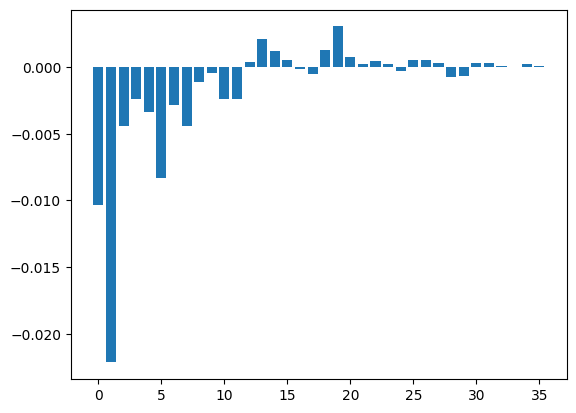

In [18]:
# training and testing
reg_lin = LR_plot(X_all, y_all) 
plt.bar(range(len(reg_lin.coef_)), reg_lin.coef_)

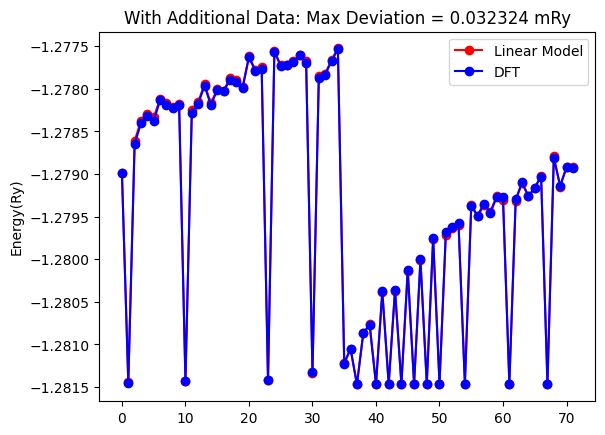

In [19]:
plt.plot(reg_lin.predict(new_data_X), "ro-", label = "Linear Model")
plt.plot(new_data_y_DFT, "bo-", label = "DFT")
error_max = max(np.array(new_data_y_DFT-reg_lin.predict(new_data_X)))
plt.title("With Additional Data: Max Deviation = %f mRy"%(1000*error_max) )
plt.ylabel("Energy(Ry)")
plt.legend()
plt.show()

## Using only random data

training R^2 score is  0.9942117856470852
training RMSE is  1.9480335764061018e-05


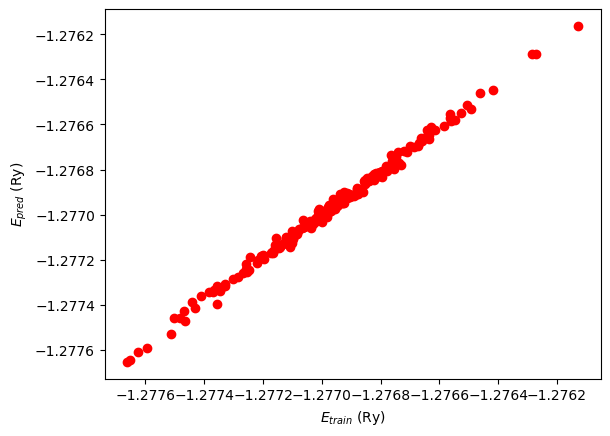

testing R^2 score is  0.9924229537169282
testing MSE is  2.4260343175438053e-05


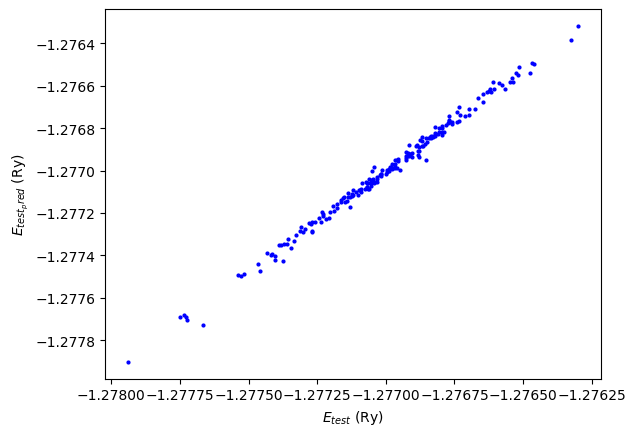

<BarContainer object of 36 artists>

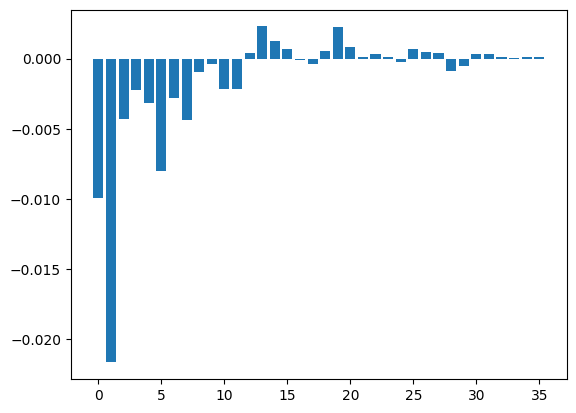

In [20]:
reg_lin_old = LR_plot(X_old, y_old) 
plt.bar(range(len(reg_lin_old.coef_)), reg_lin_old.coef_)

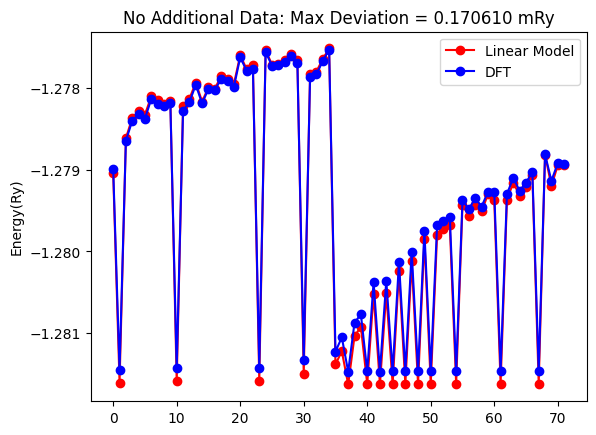

In [21]:
plt.plot(reg_lin_old.predict(new_data_X), "ro-", label="Linear Model")
plt.plot(new_data_y_DFT, "bo-", label="DFT")
error_max = max(np.array(new_data_y_DFT-reg_lin_old.predict(new_data_X)))
plt.title("No Additional Data: Max Deviation = %f mRy"%(1000*error_max) )
plt.ylabel("Energy(Ry)")
plt.legend()
plt.show()

## Quadratic fitting

training R^2 score is  0.9996523012379693
training RMSE is  1.7748553764727802e-05


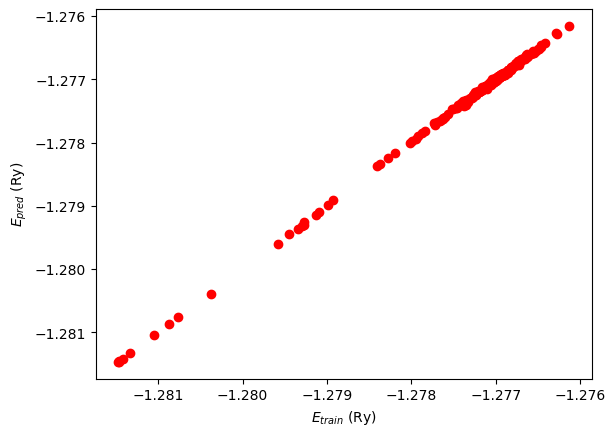

testing R^2 score is  0.999589173520446
testing MSE is  2.190802955479672e-05


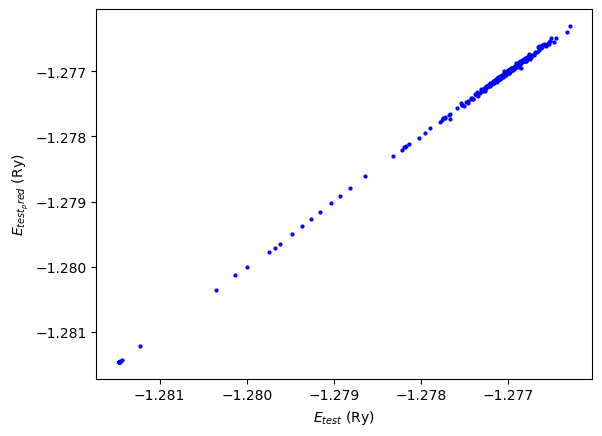

<BarContainer object of 57 artists>

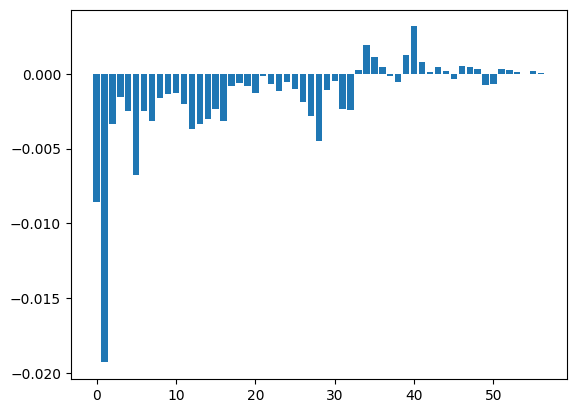

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)

X_all_poly = np.concatenate((poly.fit_transform(X_all[:,:6]), X_all[:,6:]), axis=1)

reg = LR_plot(X_all_poly, y_all) 
plt.bar(range(len(reg.coef_)), reg.coef_)

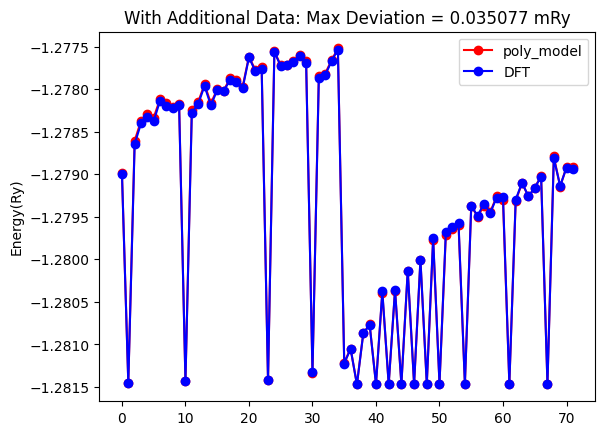

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)

new_data_X = np.array(new_data_X)

new_data_X_poly = np.concatenate((poly.fit_transform(new_data_X[:,:6]), new_data_X[:,6:]), axis=1)
plt.plot(reg.predict(new_data_X_poly), "ro-", label = "poly_model")

plt.plot(new_data_y_DFT, "bo-", label = "DFT")
plt.ylabel("Energy(Ry)")
plt.legend()

error_max = max(np.array(new_data_y_DFT-reg.predict(new_data_X_poly)))

plt.title("With Additional Data: Max Deviation = %f mRy"%(1000*error_max) )
plt.show()

## MoNbTaTiW

160Atom_1
160Atom_10
160Atom_100
160Atom_101
160Atom_102
160Atom_103
160Atom_104
160Atom_105
160Atom_106
160Atom_107
160Atom_108
160Atom_109
160Atom_11
160Atom_110
160Atom_111
160Atom_112
160Atom_113
160Atom_114
160Atom_115
160Atom_116
160Atom_117
160Atom_118
160Atom_119
160Atom_12
160Atom_120
160Atom_121
160Atom_123
160Atom_124
160Atom_125
160Atom_126
160Atom_127
160Atom_128
160Atom_129
160Atom_13
160Atom_130
160Atom_131
160Atom_132
160Atom_133
160Atom_134
160Atom_135
160Atom_136
160Atom_137
160Atom_138
160Atom_139
160Atom_14
160Atom_140
160Atom_141
160Atom_142
160Atom_143
160Atom_144
160Atom_145
160Atom_146
160Atom_147
160Atom_148
160Atom_149
160Atom_15
160Atom_150
160Atom_151
160Atom_152
160Atom_153
160Atom_154
160Atom_155
160Atom_156
160Atom_157
160Atom_158
160Atom_159
160Atom_16
160Atom_160
160Atom_161
160Atom_162
160Atom_163
160Atom_164
160Atom_165
160Atom_166
160Atom_167
160Atom_168
160Atom_169
160Atom_17
160Atom_170
160Atom_171
160Atom_172
160Atom_173
160Atom_174
160Atom_175
16

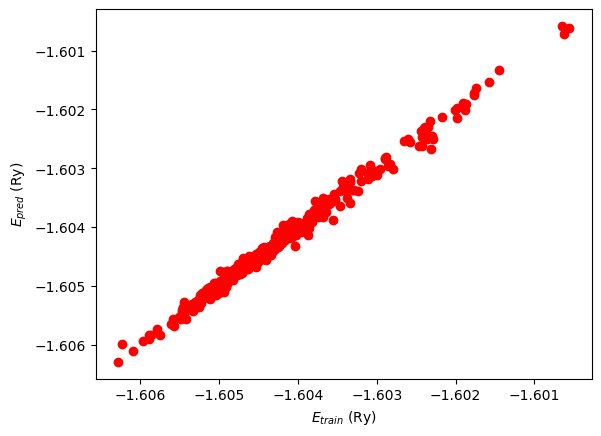

testing R^2 score is  0.9845595414918694
testing MSE is  0.00010426115510501898


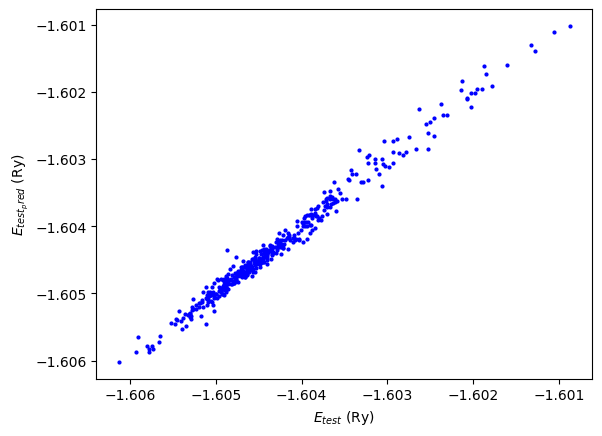

<BarContainer object of 60 artists>

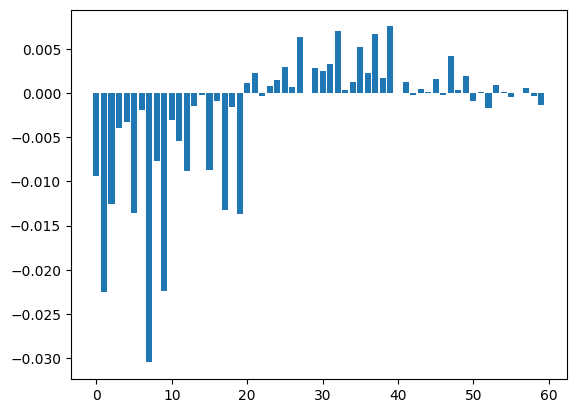

In [24]:
data_dir = os.path.join(home_dir, "Random_MoNbTaTiW")

test = Pair_energy(data_dir, n_shell=6, cell_sizes=[], n_configuration=200, verbose = True)

X_data = pd.DataFrame(test.X_data, columns=test.col_index, index=test.row_index)
X = X_data[test.col_index_short]
y = test.y_data

reg = LR_plot(X, y) 
plt.bar(range(len(reg.coef_)), reg.coef_)

In [25]:
import os

# read the positions and calculate the features
new_data_dir = os.path.join(home_dir, "MC_MoNbTaTiW/MC_data")
files = sorted(os.listdir(new_data_dir))
new_data_X = []
for file in files:
    with open(os.path.join(new_data_dir, file), 'r') as fp:
        lines = fp.readlines()
        data_raw = [float(i) for i in lines[2].split()]
        new_data_X.append(data_raw)
        
# read DFT energis from the file       
with open(os.path.join(home_dir, "MC_MoNbTaTiW/DFT_energy.dat")) as fp:
    data = [i.split(",") for i in  fp.read().splitlines()]  
energy_dict = {}
for i, j in data:
    energy_dict[i] = float(j)
new_data_y_DFT = [energy_dict[i] for i in sorted(energy_dict)]

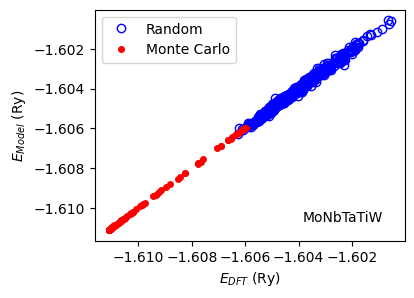

In [26]:
fig, ax = plt.subplots(figsize=(4,3))

X_old = np.array(X)
y_old = np.array(y)
X_all = np.concatenate((X_old, np.array(new_data_X)))
y_all = np.concatenate((y_old, np.array(new_data_y_DFT)))

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
y_pred = reg_lin.predict(X_all)
#plt.plot(y_all, y_pred, "ro", label="Old and additional energies")

X_new = np.array(new_data_X)
y_new = np.array(new_data_y_DFT)
plt.plot(y_old, reg_lin.predict(X_old), 'o', markerfacecolor='none', 
         label="Random", markeredgecolor='b',  markersize=6)
plt.plot(y_new, reg_lin.predict(X_new), "ro", label="Monte Carlo", markersize=4)
plt.legend()
plt.xlabel(r"$E_{DFT}$ (Ry)")
plt.ylabel(r"$E_{Model}$ (Ry)")
#plt.title(r"$R^2$=%.4f, MSRE=%.4f mRy"%(r2_score(y_all, y_pred), 
#                                    1000*np.sqrt(mean_squared_error(y_all, y_pred))))

plt.text(0.8, 0.1,'MoNbTaTiW',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

plt.savefig(os.path.join(home_dir, "figures/MoNbTaTiW_energy.pdf"), dpi = None, facecolor = 'w', edgecolor = 'w',
    format = 'pdf',
    transparent = False, bbox_inches = 'tight', pad_inches = 0.1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.5,
                                                    random_state = 111)
reg_lin = BayesianRidge()
reg_lin.fit(X_train, y_train)

print("Training R2 score = %f"%r2_score(y_train, reg_lin.predict(X_train)))
print("Testing R2 score = %f"%r2_score(y_test, reg_lin.predict(X_test)))


print("Training mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_train, reg_lin.predict(X_train)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_test, reg_lin.predict(X_test)))))

Training R2 score = 0.997833
Testing R2 score = 0.996835
Training mean sequre error = 0.080554 mRy
Testing mean sequre error = 0.099212 mRy


In [28]:
print("Fit with data_old")
reg_lin = BayesianRidge()
reg_lin.fit(X_old, y_old)

#print("Training R2 score = %f"%r2_score(y_old, reg_lin.predict(X_old)))
#print("Testing R2 score = %f"%r2_score(y_all, reg_lin.predict(X_all)))

#print("Training mean sequre error = %f mRy"
#      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

print("="*50)
print("Fit with data_all")
reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

Fit with data_old
Testing mean sequre error = 0.085572 mRy
Testing mean sequre error = 0.087601 mRy
Testing mean sequre error = 0.060054 mRy
Fit with data_all
Testing mean sequre error = 0.083916 mRy
Testing mean sequre error = 0.087630 mRy
Testing mean sequre error = 0.017405 mRy


training R^2 score is  0.997724917264725
training RMSE is  8.079691862448491e-05


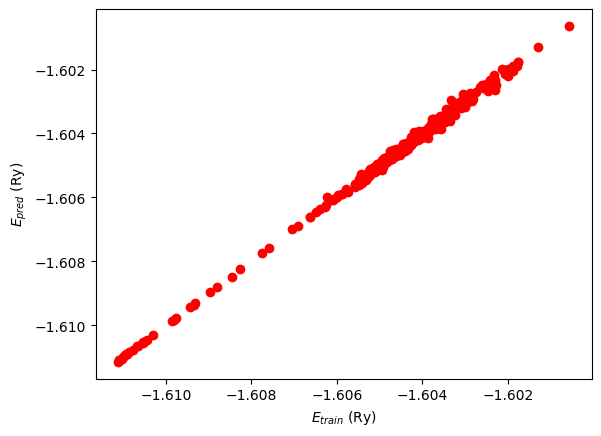

testing R^2 score is  0.997096591787422
testing MSE is  9.688850936868194e-05


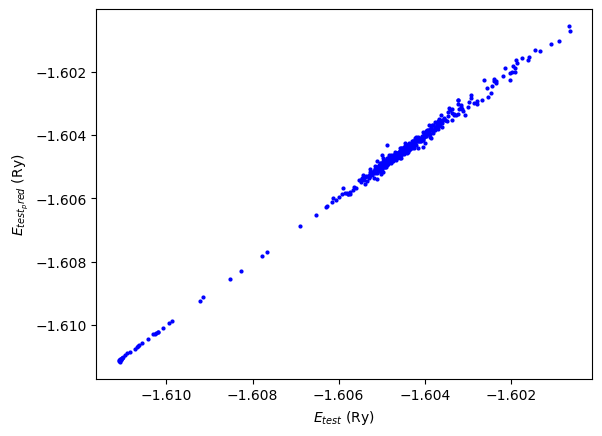

<BarContainer object of 60 artists>

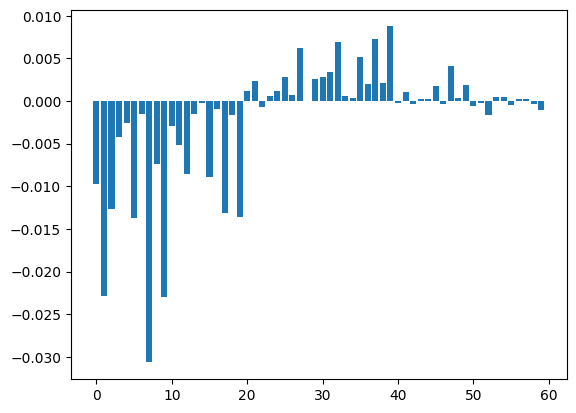

In [29]:
# training and testing
reg_lin = LR_plot(X_all, y_all) 
plt.bar(range(len(reg_lin.coef_)), reg_lin.coef_)

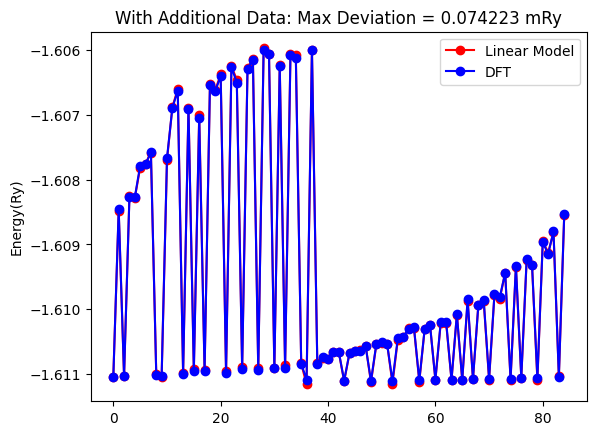

In [30]:
plt.plot(reg_lin.predict(new_data_X), "ro-", label = "Linear Model")
plt.plot(new_data_y_DFT, "bo-", label = "DFT")
error_max = max(np.array(new_data_y_DFT-reg_lin.predict(new_data_X)))
plt.title("With Additional Data: Max Deviation = %f mRy"%(1000*error_max) )
plt.ylabel("Energy(Ry)")
plt.legend()
plt.show()

## Using only random data

training R^2 score is  0.9919940721907725
training RMSE is  8.07421081912682e-05


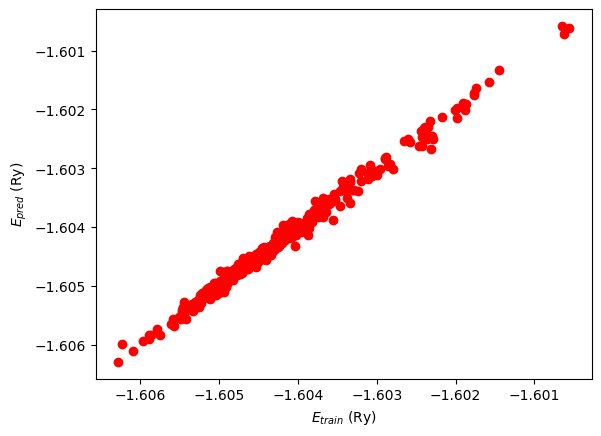

testing R^2 score is  0.9845595414918694
testing MSE is  0.00010426115510501898


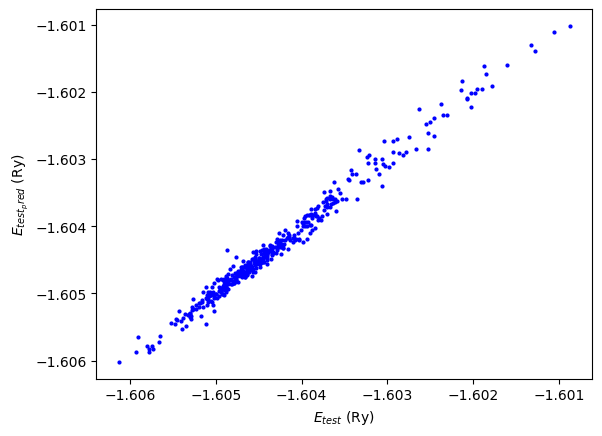

<BarContainer object of 60 artists>

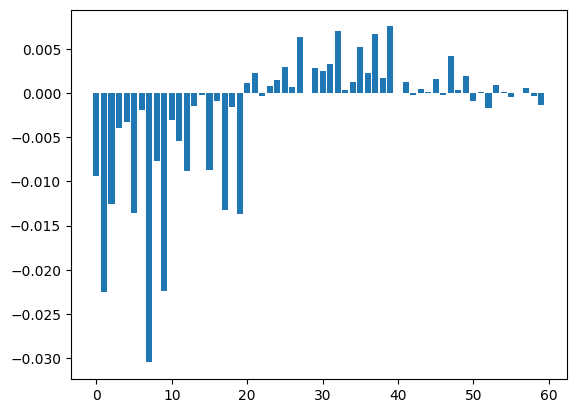

In [31]:
reg_lin_old = LR_plot(X_old, y_old) 
plt.bar(range(len(reg_lin_old.coef_)), reg_lin_old.coef_)

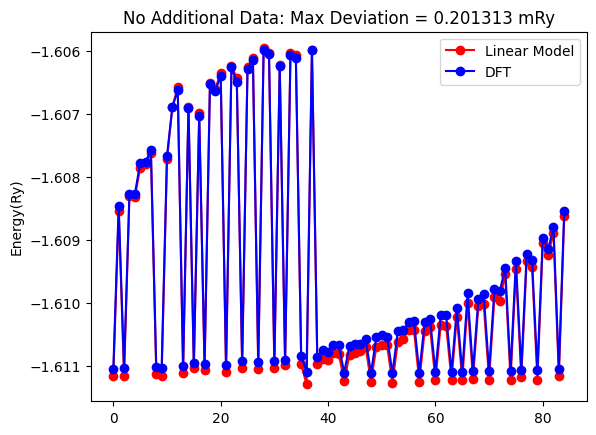

In [32]:
plt.plot(reg_lin_old.predict(new_data_X), "ro-", label="Linear Model")
plt.plot(new_data_y_DFT, "bo-", label="DFT")
error_max = max(np.array(new_data_y_DFT-reg_lin_old.predict(new_data_X)))
plt.title("No Additional Data: Max Deviation = %f mRy"%(1000*error_max) )
plt.ylabel("Energy(Ry)")
plt.legend()
plt.show()

## MoNbTaVW

In [33]:
import os
code_dir = os.getcwd()
home_dir = code_dir 

1280Atom_1
1280Atom_100
1280Atom_101
1280Atom_102
1280Atom_103
1280Atom_104
1280Atom_105
1280Atom_106
1280Atom_107
1280Atom_108
1280Atom_109
1280Atom_110
1280Atom_111
1280Atom_112
1280Atom_113
1280Atom_114
1280Atom_115
1280Atom_116
1280Atom_117
1280Atom_118
1280Atom_119
1280Atom_120
1280Atom_121
1280Atom_122
1280Atom_123
1280Atom_124
1280Atom_125
1280Atom_126
1280Atom_127
1280Atom_128
1280Atom_129
1280Atom_130
1280Atom_131
1280Atom_132
1280Atom_133
1280Atom_134
1280Atom_135
1280Atom_136
1280Atom_137
1280Atom_138
1280Atom_139
1280Atom_140
1280Atom_141
1280Atom_142
1280Atom_143
1280Atom_144
1280Atom_145
1280Atom_146
1280Atom_147
1280Atom_148
1280Atom_149
1280Atom_150
1280Atom_151
1280Atom_152
1280Atom_153
1280Atom_154
1280Atom_155
1280Atom_156
1280Atom_157
1280Atom_158
1280Atom_159
1280Atom_160
1280Atom_161
1280Atom_162
1280Atom_163
1280Atom_164
1280Atom_165
1280Atom_166
1280Atom_167
1280Atom_168
1280Atom_169
1280Atom_170
1280Atom_171
1280Atom_172
1280Atom_173
1280Atom_174
1280Atom_175
1

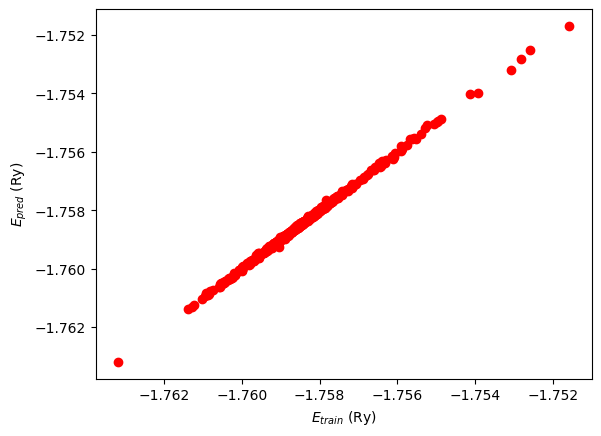

testing R^2 score is  0.9984225932223384
testing MSE is  4.3706600462850284e-05


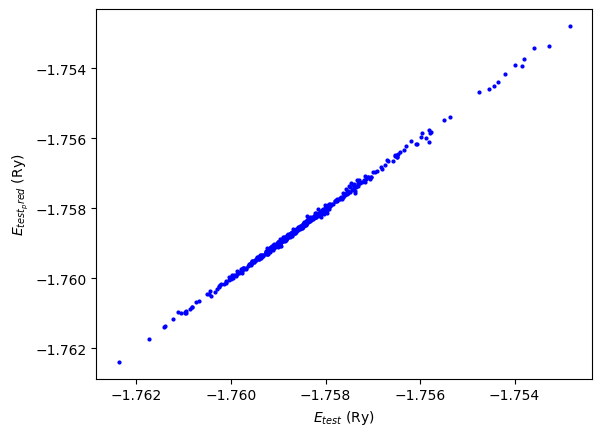

<BarContainer object of 60 artists>

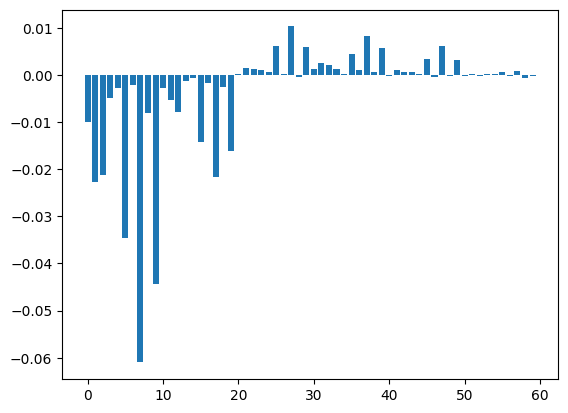

In [34]:
data_dir = os.path.join(home_dir, "Random_MoNbTaVW")

test = Pair_energy(data_dir, n_shell=6, cell_sizes=[], n_configuration=200, verbose = True)

X_data = pd.DataFrame(test.X_data, columns=test.col_index, index=test.row_index)
X = X_data[test.col_index_short]
y = test.y_data

reg = LR_plot(X, y) 
plt.bar(range(len(reg.coef_)), reg.coef_)

In [35]:
import os

# read the positions and calculate the features
new_data_dir = os.path.join(home_dir, "MC_MoNbTaVW/MC_data")
files = sorted(os.listdir(new_data_dir))
new_data_X = []
for file in files:
    with open(os.path.join(new_data_dir, file), 'r') as fp:
        lines = fp.readlines()
        data_raw = [float(i) for i in lines[2].split()]
        new_data_X.append(data_raw)
        
# read DFT energis from the file       
with open(os.path.join(home_dir, "MC_MoNbTaVW/DFT_energy.dat")) as fp:
    data = [i.split(",") for i in  fp.read().splitlines()]  
energy_dict = {}
for i, j in data:
    energy_dict[i] = float(j)
new_data_y_DFT = [energy_dict[i] for i in sorted(energy_dict)]

TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'papertype'

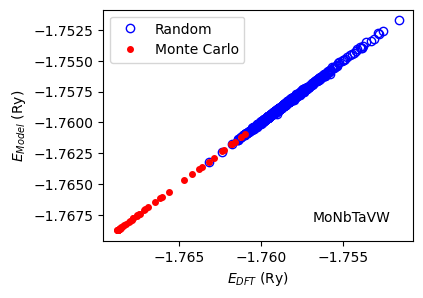

In [36]:
fig, ax = plt.subplots(figsize=(4,3))

X_old = np.array(X)
y_old = np.array(y)
X_all = np.concatenate((X_old, np.array(new_data_X)))
y_all = np.concatenate((y_old, np.array(new_data_y_DFT)))

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
y_pred = reg_lin.predict(X_all)
#plt.plot(y_all, y_pred, "ro", label="Old and additional energies")

X_new = np.array(new_data_X)
y_new = np.array(new_data_y_DFT)
plt.plot(y_old, reg_lin.predict(X_old), 'o', markerfacecolor='none', 
         label="Random", markeredgecolor='b',  markersize=6)
plt.plot(y_new, reg_lin.predict(X_new), "ro", label="Monte Carlo", markersize=4)
plt.legend()
plt.xlabel(r"$E_{DFT}$ (Ry)")
plt.ylabel(r"$E_{Model}$ (Ry)")
#plt.title(r"$R^2$=%.4f, MSRE=%.4f mRy"%(r2_score(y_all, y_pred), 
#                                    1000*np.sqrt(mean_squared_error(y_all, y_pred))))

plt.text(0.8, 0.1,'MoNbTaVW',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

plt.savefig(os.path.join(home_dir, "figures/MoNbTaVW_energy.pdf"), dpi = None, facecolor = 'w', edgecolor = 'w',
    papertype = None, format = 'pdf',
    transparent = False, bbox_inches = 'tight', pad_inches = 0.1,
    frameon = None)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.5,
                                                    random_state = 111)
reg_lin = BayesianRidge()
reg_lin.fit(X_train, y_train)

print("Training R2 score = %f"%r2_score(y_train, reg_lin.predict(X_train)))
print("Testing R2 score = %f"%r2_score(y_test, reg_lin.predict(X_test)))


print("Training mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_train, reg_lin.predict(X_train)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_test, reg_lin.predict(X_test)))))

Training R2 score = 0.999705
Testing R2 score = 0.999498
Training mean sequre error = 0.032232 mRy
Testing mean sequre error = 0.044393 mRy


In [38]:
print("Fit with data_old")
reg_lin = BayesianRidge()
reg_lin.fit(X_old, y_old)

#print("Training R2 score = %f"%r2_score(y_old, reg_lin.predict(X_old)))
#print("Testing R2 score = %f"%r2_score(y_all, reg_lin.predict(X_all)))

#print("Training mean sequre error = %f mRy"
#      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

print("="*50)
print("Fit with data_all")
reg_lin = BayesianRidge()
reg_lin.fit(X_all, y_all)
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_all, reg_lin.predict(X_all)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_old, reg_lin.predict(X_old)))))
print("Testing mean sequre error = %f mRy"
      %(1000*np.sqrt(mean_squared_error(y_new, reg_lin.predict(X_new)))))

Fit with data_old
Testing mean sequre error = 0.038416 mRy
Testing mean sequre error = 0.036534 mRy
Testing mean sequre error = 0.071383 mRy
Fit with data_all
Testing mean sequre error = 0.036049 mRy
Testing mean sequre error = 0.036635 mRy
Testing mean sequre error = 0.014405 mRy
